<a href="https://colab.research.google.com/github/valmeau/w07-final-project/blob/master/bvh_exploratory_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 - Forest Cover Type Prediction

## Final Project Baseline

## Team:
- Brittney Van Hese
- Prabhaker Narsina
- Valérie Méausoone


### Environment Set-Up

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
#from google.colab import files
import io

%matplotlib inline

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### **Exploratory Data Analysis**
We perform an EDA on the training dataset provided by the Kaggle competition.

#### Importing the Data

To begin, we import that training data set that is provided for us as a part of the problem. Then we display the columns found in our data set, along with a preview of the data contained within.

In [3]:
#uploading train data to colab - this command only needs to be run once. 
#uploaded_train = files.upload()

#train_df = pd.read_csv(io.BytesIO(uploaded_train['train.csv']), index_col='Id')
train_df = pd.read_csv('input/train.csv', index_col='Id')
col_names = train_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample data:")
train_df.head()

Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:


Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
Id                                                               
1        2596      51      3                               258   
2        2590      56      2                               212   
3        2804     139      9                               268   
4        2785     155     18                               242   
5        2595      45      2                               153   

    Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
Id                                                                    
1                                0                              510   
2                               -6                              390   
3                               65                             3180   
4                              118                             3090   
5                               -1                              391   

    Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
Id                                                 
1             221             232            148   
2             220             235            151   
3             234             238            135   
4             238             238            122   
5             220             234            150   

    Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
Id                                      ...                             
1                                 6279  ...            0            0   
2                                 6225  ...            0            0   
3                                 6121  ...            0            0   
4                                 6211  ...            0            0   
5                                 6172  ...            0            0   

    Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
Id                                                                    
1             0            0            0            0            0   
2             0            0            0            0            0   
3             0            0            0            0            0   
4             0            0            0            0            0   
5             0            0            0            0            0   

    Soil_Type39  Soil_Type40  Cover_Type  
Id                                        
1             0            0           5  
2             0            0           5  
3             0            0           2  
4             0            0           2  
5             0            0           5  

[5 rows x 55 columns]

From the problem prompt, the objective is to predict the Cover Type, or tree coverage species, to be expected in an area given the descriptive features of the area like: Elevation, shade levels, and distance to nearby water and roads. Therefore, we will separate out the target class to be predicted and count the remaining features and the total number of observations they describe. 

In [4]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out features for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space hold 15120 observations and 54 features
Unique target labels: [1 2 3 4 5 6 7]


#### Assessing Data Quality

Before attempting any predictions, it is important we check the training data that will be passed to any models. Here we check of any missing or erroneous values. 

In [5]:
# Assessing missingness
print("There are", np.count_nonzero(np.isnan(X)), "missing values among our features")
print("There are", np.count_nonzero(np.isnan(y)), "missing values among our target values")

#Assessing plausibility of values
print("\nLooking at summary statistics for our training data:")
train_df.describe()

There are 0 missing values among our features
There are 0 missing values among our target values

Looking at summary statistics for our training data:


Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       79.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1714.023214     212.704299      218.965608   
std                        1325.066358      30.561287       22.801966   
min                           0.000000       0.000000       99.000000   
25%                         764.000000     196.000000      207.000000   
50%                        1316.000000     220.000000      223.000000   
75%                        2270.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  ...   Soil_Type32  \
count   15120.000000                        15120.000000  ...  15120.000000   
mean      135.091997                         1511.147288  ...      0.045635   
std        45.895189                         1099.936493  ...      0.208699   
min         0.000000                            0.000000  ...      0.000000   
25%       106.000000                          730.000000  ...      0.000000   
50%       138.000000                         1256.000000  ...      0.000000   
75%       167.000000                         1988.250000  ...      0.000000   
max       248.000000                         6993.000000  ...      1.000000   

        Soil_Type33   Soil_Type34   Soil_Type35   Soil_Type36   Soil_Type37  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.040741      0.001455      0.006746      0.000661      0.002249   
std        0.197696      0.038118      0.081859      0.025710      0.047368   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type38   Soil_Type39   Soil_Type40    Cover_Type  
count  15120.000000  15120.000000  15120.000000  15120.000000  
mean       0.048148      0.043452      0.030357      4.000000  
std        0.214086      0.203880      0.171574      2.000066  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.000000      0.000000      0.000000      2.000000  
50%        0.000000      0.000000      0.000000      4.000000  
75%        0.000000      0.000000      0.000000      6.000000  
max        1.000000      1.000000      1.000000      7.000000  

[8 rows x 55 columns]

The variables all have plausible distributions. We notice a negative minimum for "Vertical_Distance_To_Hydrology" but understand that it is a plausible minimum value, as the surface of the nearest water source for areas - such as mountainous regions - will be beneath the area being evaluated. 

Therefore, we conclude there are no obvious issues with the data set and proceed with exploration of the features.



#### Feature Exploration

First, we ensure that each target class is represented fairly in the data set. 

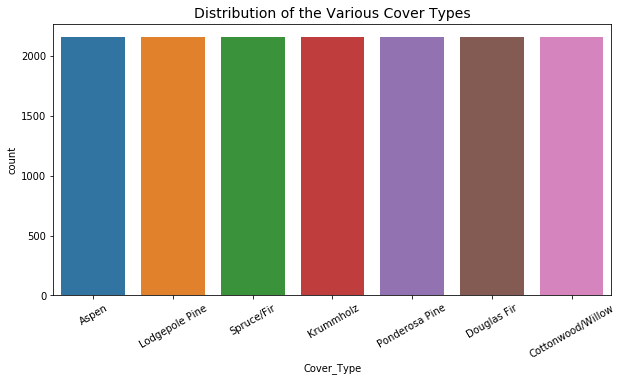

In [6]:
#Plotting the target
#Renaming the target labels to make them more meaningful
train_df['Cover_Type'].replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Cover_Type", data = train_df)

From the figure above, it is clear that each target class is equally represented in the data set. Next, we see if any of the features offer distinctions between our Cover Types; starting with our categorical features. 

In [7]:
#Plotting catgorical features
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
train_df = train_df.rename(columns={"Wilderness_Area1":"Rawah_WA","Wilderness_Area2":"Neota_WA",
"Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA"})
train_df['Wilderness_Areas'] = (train_df.iloc[:,10:14] == 1).idxmax(1)

fig = px.histogram(train_df, x="Wilderness_Areas", color="Cover_Type", barmode="group", title='Distribution of Wildreness Area by Cover Type')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [8]:
train_df['Soil_Type'] = (train_df.iloc[:,15:55] == 1).idxmax(1)
fig = px.histogram(train_df, x="Soil_Type", color="Cover_Type", title='Distribution of the Soil Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Each of our categorical feature values appear to provide separation between our target classes. Next let us look at the distributions of our numerical features.

<Figure size 1152x576 with 0 Axes>

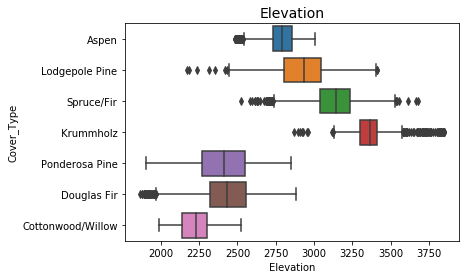

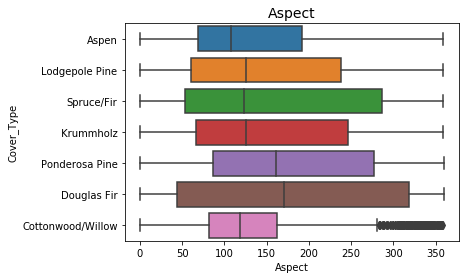

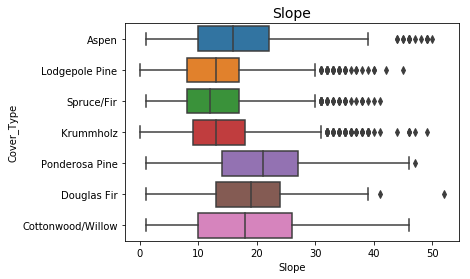

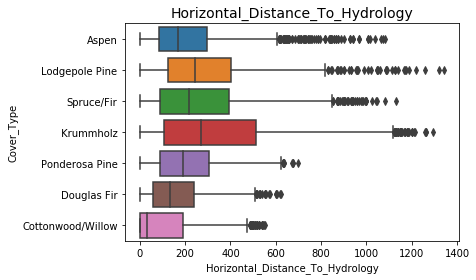

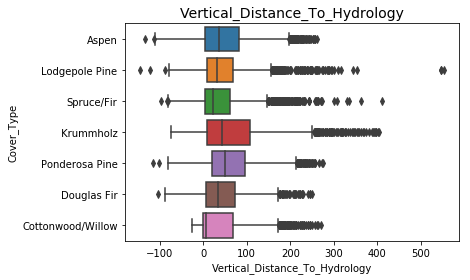

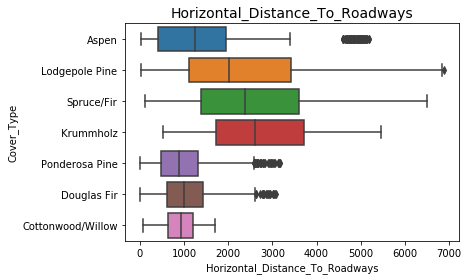

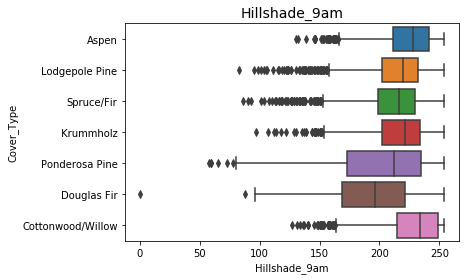

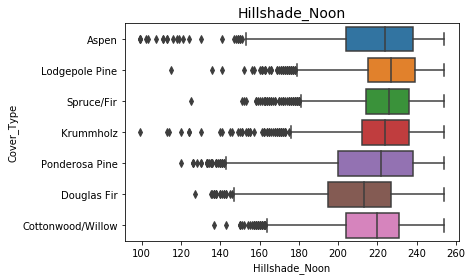

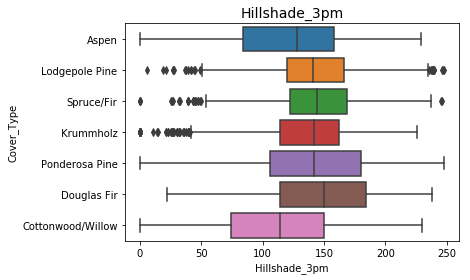

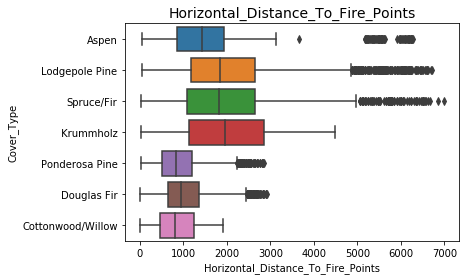

In [9]:
#Plotting and grouping numerical features according to target classes
plt.figure(figsize=(16, 8))

num_values_range = 10
# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(num_values_range):
    fig1, ax1 = plt.subplots()
    ax1.set_title(train_df.columns[feature], size = 14)
    ax1 = sns.boxplot(x = train_df.columns[feature], y = 'Cover_Type' , data = train_df)

From all the above plots, we do see some separation between features and classes, but we also see significant overlap of the numerical feature distributions. This could cause problems for our predictions depending on the model we select.

## Distributions

(array([  3.,   7.,  14.,  12.,  18.,  18.,  28.,  57.,  99., 107., 141.,
        116., 186., 192., 160., 165., 205., 219., 205., 232., 253., 280.,
        306., 290., 270., 251., 225., 226., 214., 193., 188., 167., 161.,
        185., 175., 199., 184., 190., 158., 162., 136., 203., 246., 287.,
        288., 252., 274., 277., 272., 226., 239., 282., 236., 204., 215.,
        185., 183., 156., 153., 176., 155., 156., 168., 128., 148., 178.,
        191., 195., 232., 246., 214., 185., 232., 209., 210., 262., 259.,
        242., 179., 100.,  64.,  44.,  33.,  27.,  12.,  10.,  14.,   8.,
          2.,   3.,   1.,   9.,   9.,  11.,   4.,   5.,   1.,   3.,  10.,
         10.]),
 array([1863.  , 1882.86, 1902.72, 1922.58, 1942.44, 1962.3 , 1982.16,
        2002.02, 2021.88, 2041.74, 2061.6 , 2081.46, 2101.32, 2121.18,
        2141.04, 2160.9 , 2180.76, 2200.62, 2220.48, 2240.34, 2260.2 ,
        2280.06, 2299.92, 2319.78, 2339.64, 2359.5 , 2379.36, 2399.22,
        2419.08, 2438.94, 2458.8 ,

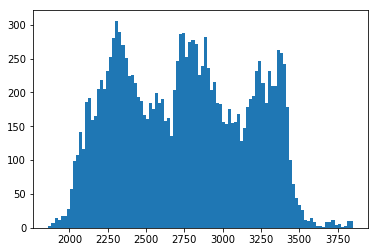

In [12]:
plt.hist(train_df['Elevation'], bins = 100)

(array([262., 202., 156., 200., 129., 213., 214., 180., 192., 192., 237.,
        222., 175., 251., 208., 262., 265., 209., 233., 153., 264., 249.,
        200., 261., 175., 284., 234., 193., 261., 186., 263., 217., 187.,
        259., 171., 238., 198., 142., 166., 122., 162., 140.,  91., 127.,
         85., 150., 134.,  94., 116.,  89., 128., 101.,  94., 112.,  58.,
        101., 104.,  72.,  93.,  64.,  75.,  68.,  49.,  75.,  59.,  72.,
         71.,  53.,  55.,  44.,  86.,  70.,  65.,  76.,  55.,  98.,  98.,
         52., 105.,  82., 120., 126.,  80., 128.,  92., 165., 190., 145.,
        187., 138., 200., 200., 148., 204., 145., 221., 192., 150., 201.,
        140.]),
 array([  0. ,   3.6,   7.2,  10.8,  14.4,  18. ,  21.6,  25.2,  28.8,
         32.4,  36. ,  39.6,  43.2,  46.8,  50.4,  54. ,  57.6,  61.2,
         64.8,  68.4,  72. ,  75.6,  79.2,  82.8,  86.4,  90. ,  93.6,
         97.2, 100.8, 104.4, 108. , 111.6, 115.2, 118.8, 122.4, 126. ,
        129.6, 133.2, 136.8, 140.4

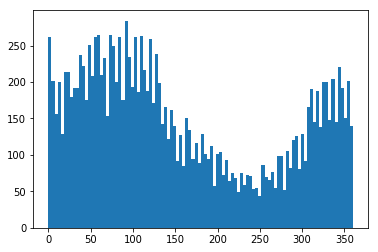

In [13]:
plt.hist(train_df['Aspect'], bins = 100)

(array([ 83., 134., 210., 305., 423., 465., 573., 574., 664., 739., 740.,
        677., 717., 699., 664., 640., 598., 558., 519., 552., 465., 458.,
        450., 394., 359., 626., 313., 258., 216., 218., 187., 143., 131.,
        101.,  68.,  58.,  36.,  32.,  16.,  18.,   3.,   2.,   5.,   3.,
         15.,   3.,   1.,   5.,   1.,   1.]),
 array([ 0.  ,  1.04,  2.08,  3.12,  4.16,  5.2 ,  6.24,  7.28,  8.32,
         9.36, 10.4 , 11.44, 12.48, 13.52, 14.56, 15.6 , 16.64, 17.68,
        18.72, 19.76, 20.8 , 21.84, 22.88, 23.92, 24.96, 26.  , 27.04,
        28.08, 29.12, 30.16, 31.2 , 32.24, 33.28, 34.32, 35.36, 36.4 ,
        37.44, 38.48, 39.52, 40.56, 41.6 , 42.64, 43.68, 44.72, 45.76,
        46.8 , 47.84, 48.88, 49.92, 50.96, 52.  ]),
 <a list of 50 Patch objects>)

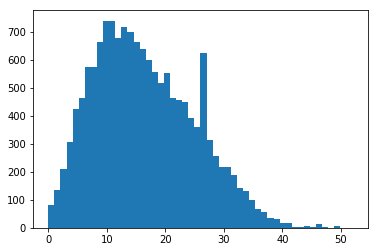

In [15]:
plt.hist(train_df['Slope'], bins = 50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 6.000e+00,
        8.000e+00, 1.300e+01, 1.600e+01, 2.400e+01, 3.700e+01, 4.000e+01,
        6.900e+01, 8.600e+01, 9.300e+01, 9.100e+01, 1.310e+02, 1.470e+02,
        1.810e+02, 1.890e+02, 2.420e+02, 2.730e+02, 3.210e+02, 3.870e+02,
        4.610e+02, 6.300e+02, 6.220e+02, 6.650e+02, 7.440e+02, 8.580e+02,
        9.200e+02, 1.153e+03, 1.263e+03, 1.250e+03, 1.102e+03, 1.005e+03,
        9.370e+02, 1.140e+03]),
 array([  0.  ,   5.08,  10.16,  15.24,  20.32,  25.4 ,  30.48,  35.56,
         40.64,  45.72,  50.8 ,  55.88,  60.96,  66.04,  71.12,  76.2 ,
         81.28,  86.36,  91.44,  96.52, 101.6 , 106.68, 111.76, 116.84,
        121.92, 127.  , 132.08, 137.16, 142.24, 147.32, 152.4 , 157.48,
        162.56, 167.64, 172.72, 177.8 , 182.88, 187.96, 193.04, 198.12,
        203.2 , 

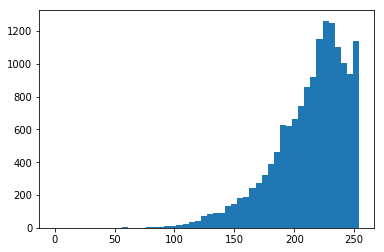

In [16]:
plt.hist(train_df['Hillshade_9am'], bins = 50)

(array([5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 7.000e+00, 2.000e+00, 1.000e+01, 8.000e+00,
        1.100e+01, 1.800e+01, 1.000e+01, 2.500e+01, 3.100e+01, 4.000e+01,
        5.900e+01, 5.400e+01, 9.800e+01, 8.000e+01, 1.220e+02, 1.190e+02,
        1.100e+02, 1.400e+02, 1.540e+02, 2.300e+02, 2.520e+02, 2.420e+02,
        3.930e+02, 3.310e+02, 3.540e+02, 4.410e+02, 5.280e+02, 5.630e+02,
        6.680e+02, 7.840e+02, 7.870e+02, 8.610e+02, 1.263e+03, 9.070e+02,
        8.930e+02, 7.620e+02, 7.080e+02, 6.120e+02, 6.220e+02, 6.310e+02,
        5.390e+02, 6.310e+02]),
 array([ 99. , 102.1, 105.2, 108.3, 111.4, 114.5, 117.6, 120.7, 123.8,
        126.9, 130. , 133.1, 136.2, 139.3, 142.4, 145.5, 148.6, 151.7,
        154.8, 157.9, 161. , 164.1, 167.2, 170.3, 173.4, 176.5, 179.6,
        182.7, 185.8, 188.9, 192. , 195.1, 198.2, 201.3, 204.4, 207.5,
        210.6, 213.7, 216.8, 219.9, 223. , 226.1, 229.2, 232.3, 235.4,
        238.5, 241.6,

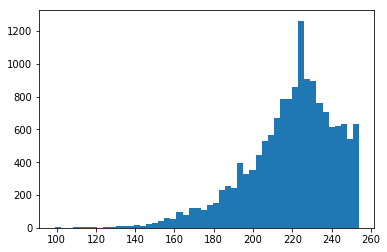

In [18]:
plt.hist(train_df['Hillshade_Noon'], bins = 50)

(array([ 93.,   6.,  25.,  31.,  47.,  68.,  78., 103., 106., 111., 136.,
        174., 201., 195., 229., 255., 283., 303., 335., 416., 418., 460.,
        504., 585., 446., 607., 707., 716., 704., 654., 713., 642., 601.,
        536., 500., 463., 479., 392., 349., 300., 240., 218., 187., 178.,
        110.,  82.,  55.,  40.,  22.,  17.]),
 array([  0.  ,   4.96,   9.92,  14.88,  19.84,  24.8 ,  29.76,  34.72,
         39.68,  44.64,  49.6 ,  54.56,  59.52,  64.48,  69.44,  74.4 ,
         79.36,  84.32,  89.28,  94.24,  99.2 , 104.16, 109.12, 114.08,
        119.04, 124.  , 128.96, 133.92, 138.88, 143.84, 148.8 , 153.76,
        158.72, 163.68, 168.64, 173.6 , 178.56, 183.52, 188.48, 193.44,
        198.4 , 203.36, 208.32, 213.28, 218.24, 223.2 , 228.16, 233.12,
        238.08, 243.04, 248.  ]),
 <a list of 50 Patch objects>)

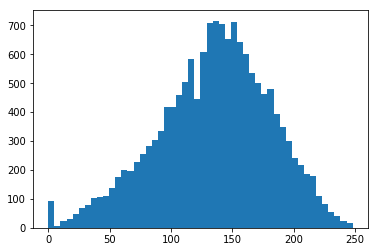

In [20]:
plt.hist(train_df['Hillshade_3pm'], bins = 50)

In [25]:
def add_feature(data):   
    data['Distance_to_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    return data

train_df = add_feature(train_df)

(array([1.590e+03, 1.659e+03, 8.990e+02, 9.450e+02, 9.850e+02, 7.900e+02,
        7.150e+02, 8.240e+02, 7.060e+02, 6.380e+02, 6.660e+02, 6.090e+02,
        5.300e+02, 4.630e+02, 4.200e+02, 3.640e+02, 3.230e+02, 2.540e+02,
        2.440e+02, 1.980e+02, 1.770e+02, 1.560e+02, 1.290e+02, 1.120e+02,
        7.700e+01, 6.900e+01, 5.800e+01, 6.300e+01, 4.300e+01, 4.600e+01,
        3.900e+01, 3.500e+01, 3.300e+01, 2.800e+01, 2.800e+01, 3.200e+01,
        2.500e+01, 2.100e+01, 1.300e+01, 2.000e+01, 2.000e+01, 2.200e+01,
        1.700e+01, 1.200e+01, 8.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00]),
 array([   0.        ,   27.13879142,   54.27758285,   81.41637427,
         108.5551657 ,  135.69395712,  162.83274855,  189.97153997,
         217.1103314 ,  244.24912282,  271.38791425,  298.52670567,
         325.6654971 ,  352.80428852,  379.94307995,  407.08187137,
         434.2206628 ,  461.35945422,  488.49824565,  515.63703707,
         542.7758285 ,  569.91461992

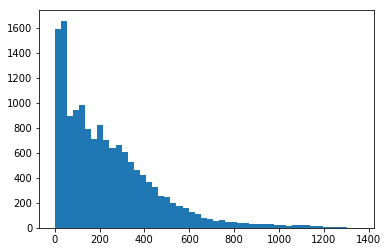

In [27]:
plt.hist(train_df['Distance_to_Hydrology'], bins = 50)

In [31]:
subset_df = train_df[['Slope', 'Aspect', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']]

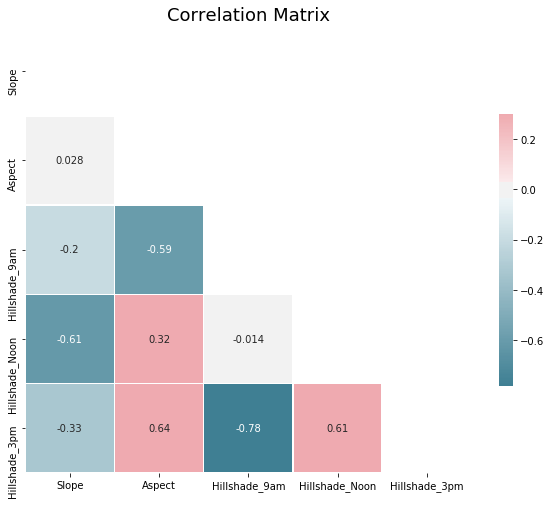

In [111]:
# Compute the correlation matrix 
#corr_data = train_df.copy()
corr = subset_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax.set_title("Correlation Matrix", size = 18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


#### Feature Covariance Matrix

The last feature evaluation step we will take is an look at feature covariance. 

In [22]:
label_classes = classes=[1, 2, 3,4,5,6,7]
y_binarized = label_binarize(y, label_classes)
outcome_df = pd.DataFrame(y_binarized, columns = ['Spruce_Fir','Lodgepole_Pine','Ponderosa Pine','Cottonwood_Willow', 'Aspen','Douglas Fir','Krummholz'])
corr_data = pd.concat([train_df.iloc[:,0:54], outcome_df], axis=1, sort=False)

/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



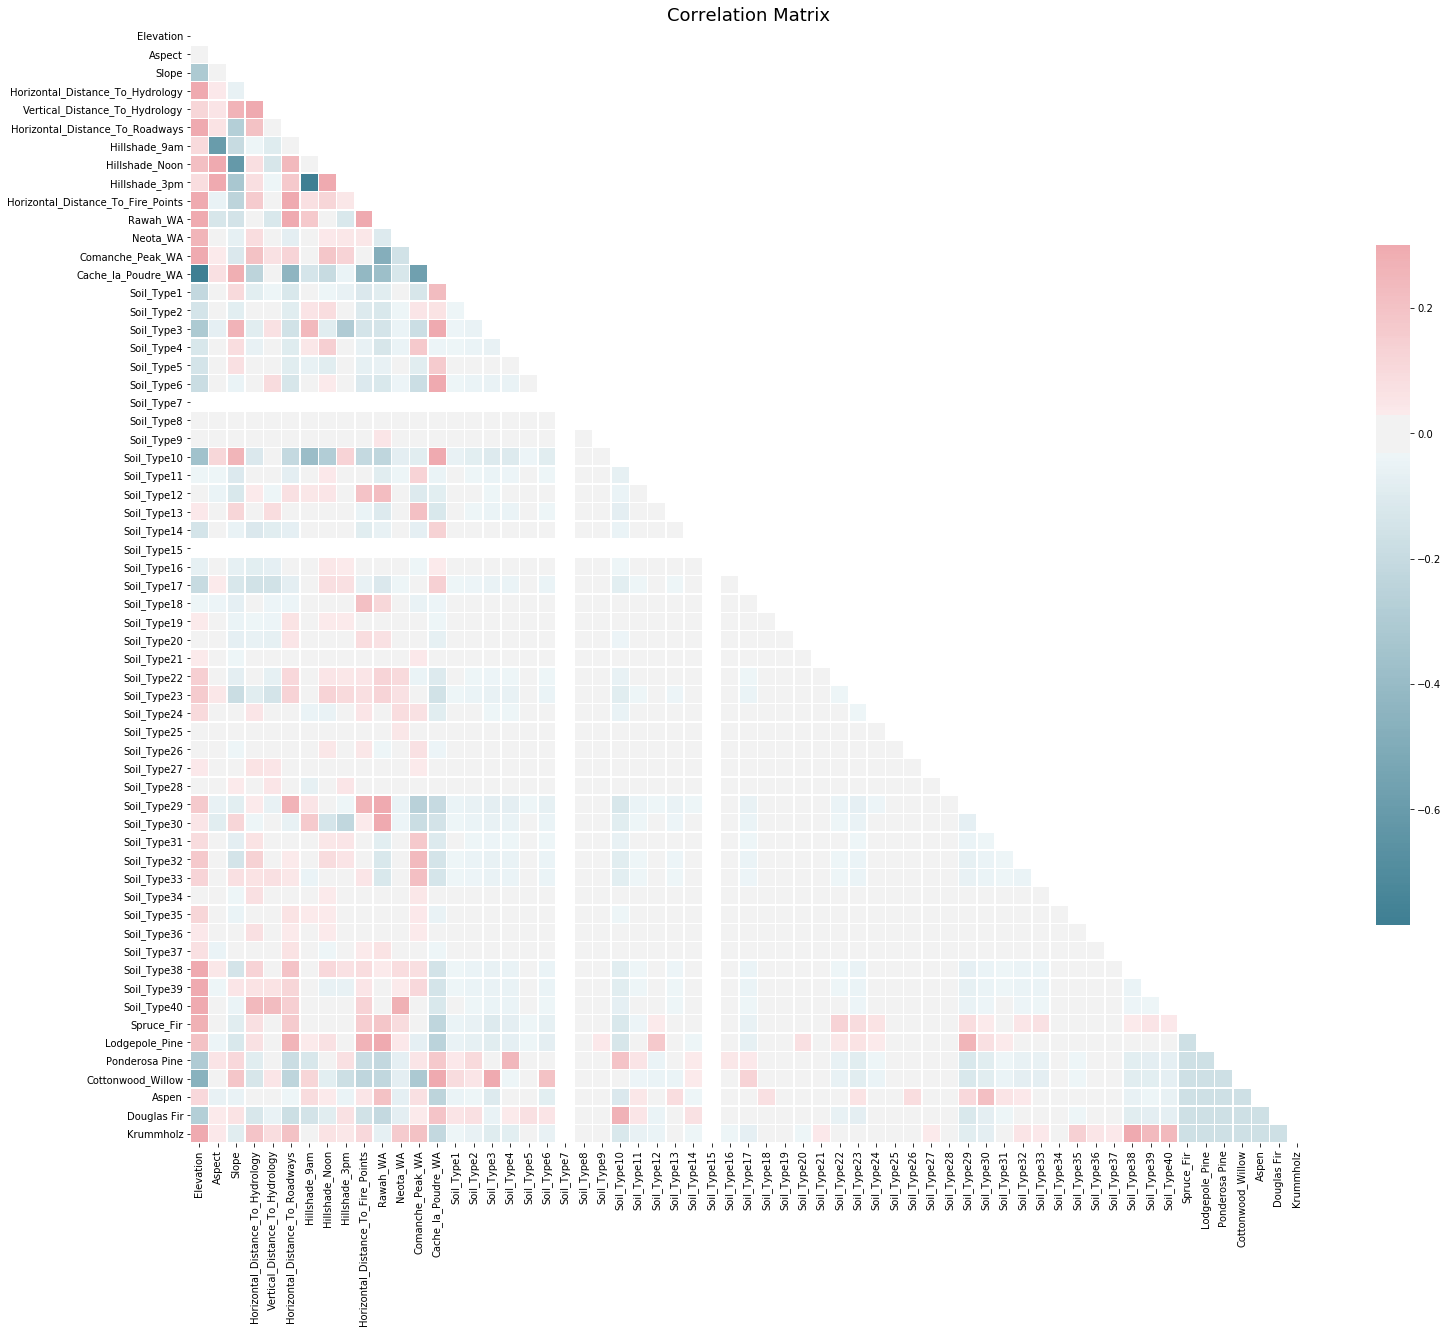

In [23]:
# Compute the correlation matrix 
#corr_data = train_df.copy()
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax.set_title("Correlation Matrix", size = 18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


We identify that a small number of variables exhibit high negative correlations (< -0.6) between each other: the Cache La Poudre wilderness area with elevation and Hillshade at different times of the day. 

## PCA

The total variance explained by the first 1 component(s) is 72.2 %
The total variance explained by the first 2 component(s) is 94.8 %
The total variance explained by the first 3 component(s) is 98.3 %
The total variance explained by the first 4 component(s) is 99.5 %
The total variance explained by the first 5 component(s) is 99.9 %
The total variance explained by the first 10 component(s) is 100.0 %
The total variance explained by the first 20 component(s) is 100.0 %
The total variance explained by the first 30 component(s) is 100.0 %
The total variance explained by the first 40 component(s) is 100.0 %
The total variance explained by the first 50 component(s) is 100.0 %


Text(0, 0.5, 'Percent variance explained')

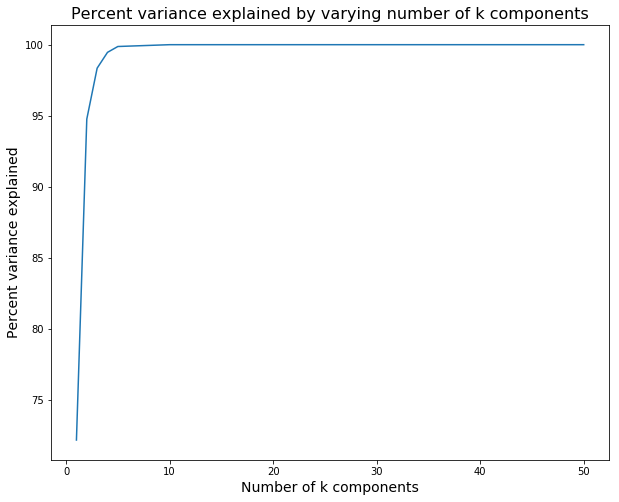

In [34]:
from sklearn.decomposition import PCA

#################################################################################################################
# Principal component analysis with varying components
##################################################################################################################

#List of key components
k=[1, 2, 3, 4, 5, 10, 20, 30, 40, 50]

#List of variances
total_variance_ls = []

#Principal component analysis
for k_value in k:        
    pca = PCA(n_components = k_value)
    pca.fit(X)
    total_variance = 100*sum(pca.explained_variance_ratio_)
    print("The total variance explained by the first", k_value, "component(s) is", round(total_variance,1), "%")
    total_variance_ls.append(total_variance)

#Plotting k components versus variance
plt.figure(figsize=(10,8))
plt.plot(k, total_variance_ls)
plt.title("Percent variance explained by varying number of k components", size = 16)
plt.xlabel('Number of k components', size = 14)
plt.ylabel('Percent variance explained', size=14)

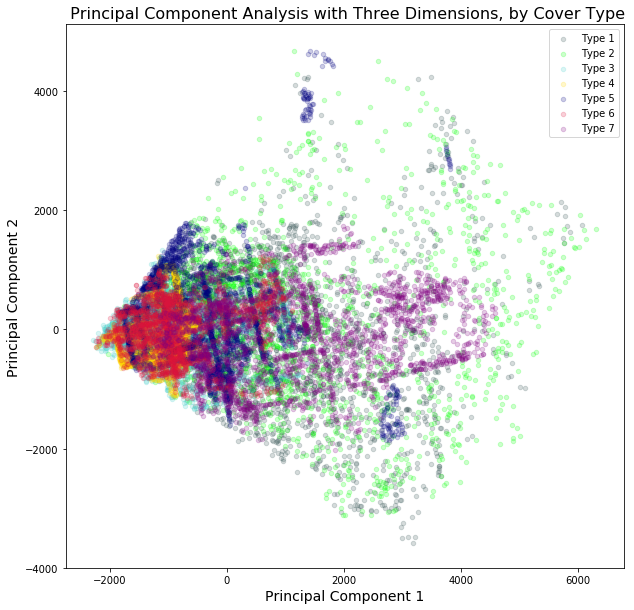

In [99]:
#################################################################################################################
# Visualizating data: producting a square scatterplot from 2-component PCA
##################################################################################################################

#Principal component analysis
pca = PCA(n_components = 3)
projection = pca.fit_transform(X)
type1 = projection[np.where(y==1)[0],:]
type2 = projection[np.where(y==2)[0],:]
type3 = projection[np.where(y==3)[0],:]
type4 = projection[np.where(y==4)[0],:]
type5 = projection[np.where(y==5)[0],:]
type6 = projection[np.where(y==6)[0],:]
type7 = projection[np.where(y==7)[0],:]

#Plotting square scatterplot
plt.figure(figsize=(10,10))
plt.scatter(type1[:,0],  type1[:,1], color = 'darkslategray' , alpha=0.2, s=20, label="Type 1")
plt.scatter(type2[:,0],  type2[:,1], color = 'lime' , alpha=0.2, s=20, label = "Type 2")
plt.scatter(type3[:,0],  type3[:,1], color = 'mediumturquoise' , alpha=0.2, s=20, label = "Type 3")
plt.scatter(type4[:,0],  type4[:,1], color = 'gold' , alpha=0.2, s=20, label = "Type 4")
plt.scatter(type5[:,0],  type5[:,1], color = 'navy' , alpha=0.2, s=20, label = "Type 5")
plt.scatter(type6[:,0],  type6[:,1], color = 'crimson' , alpha=0.2, s=20, label = "Type 6")
plt.scatter(type7[:,0],  type7[:,1], color = 'purple' , alpha=0.2, s=20, label = "Type 7")
plt.title(" Principal Component Analysis with Three Dimensions, by Cover Type", size = 16)
plt.xlabel('Principal Component 1', size = 14)
plt.ylabel('Principal Component 2', size=14)
plt.legend()

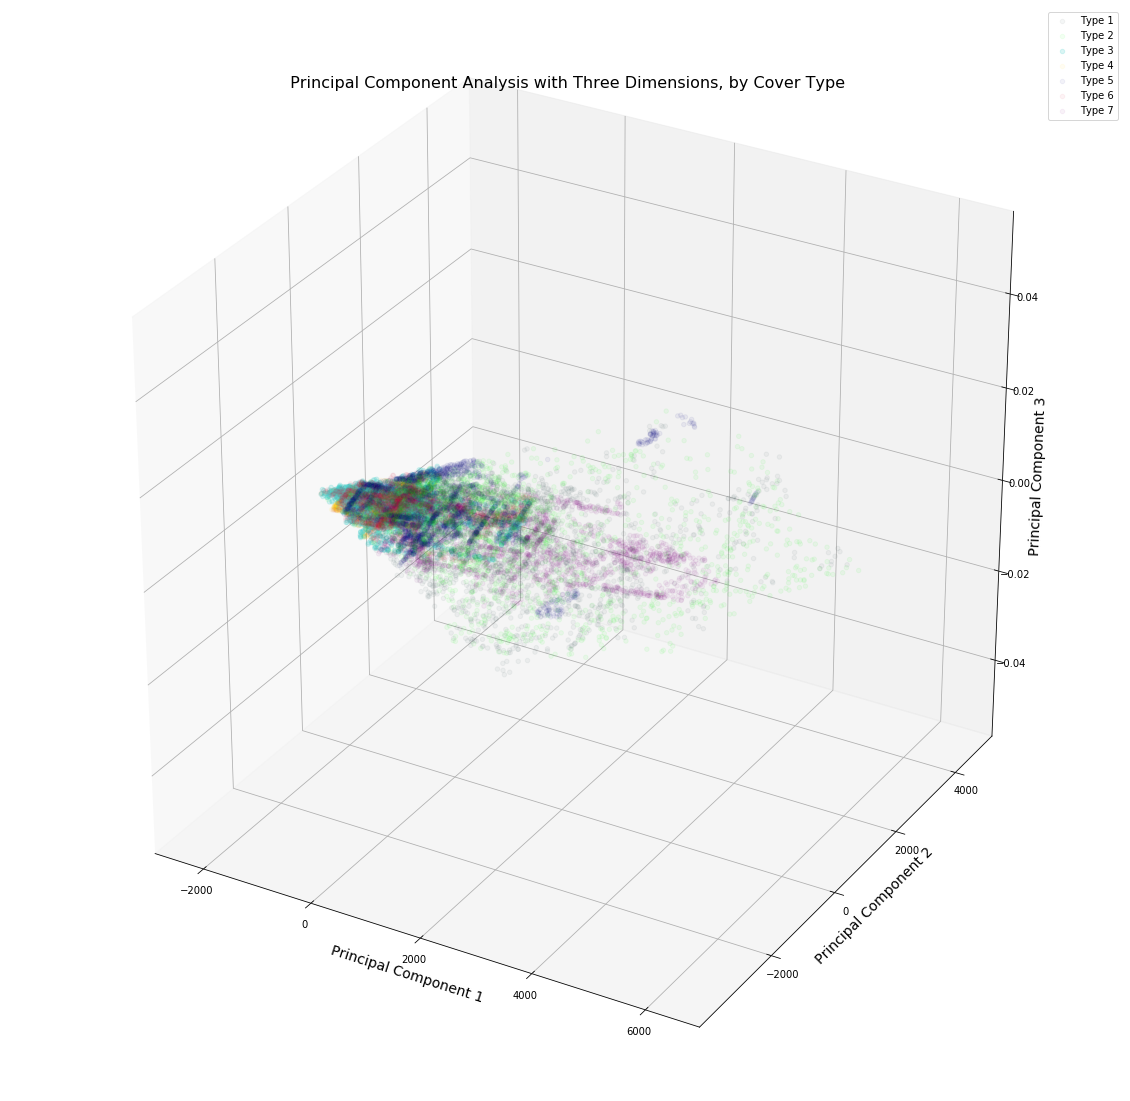

In [110]:
from mpl_toolkits.mplot3d import Axes3D 

#################################################################################################################
# Visualizating data: producting a square scatterplot from 2-component PCA
##################################################################################################################

#Principal component analysis
#r = np.exp(-(X ** 2).sum(1))
pca = PCA(n_components=3)
model = pca.fit_transform(X)
type1 = model[np.where(y==1)[0],:]
type2 = model[np.where(y==2)[0],:]
type3 = model[np.where(y==3)[0],:]
type4 = model[np.where(y==4)[0],:]
type5 = model[np.where(y==5)[0],:]
type6 = model[np.where(y==6)[0],:]
type7 = model[np.where(y==7)[0],:]
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs=model[:, 0], ys=model[:, 1], zs=r, c=y, s=50, cmap='tab20b')
ax.scatter(xs=type1[:,0],  ys=type1[:,1], zs=np.exp(-(type1 ** 2).sum(1)), color = 'darkslategray' , alpha=0.05, s=20, label="Type 1")
ax.scatter(xs=type2[:,0],  ys=type2[:,1], zs=np.exp(-(type2 ** 2).sum(1)), color = 'lime' , alpha=0.05, s=20, label = "Type 2")
ax.scatter(xs=type3[:,0],  ys=type3[:,1], zs=np.exp(-(type3 ** 2).sum(1)), color = 'mediumturquoise' , alpha=0.2, s=20, label = "Type 3")
ax.scatter(xs=type4[:,0],  ys=type4[:,1], zs=np.exp(-(type4 ** 2).sum(1)), color = 'gold' , alpha=0.05, s=20, label = "Type 4")
ax.scatter(xs=type5[:,0],  ys=type5[:,1], zs=np.exp(-(type5 ** 2).sum(1)), color = 'navy' , alpha=0.05, s=20, label = "Type 5")
ax.scatter(xs=type6[:,0],  ys=type6[:,1], zs=np.exp(-(type6 ** 2).sum(1)), color = 'crimson' , alpha=0.05, s=20, label = "Type 6")
ax.scatter(xs=type7[:,0],  ys=type7[:,1], zs=np.exp(-(type7 ** 2).sum(1)), color = 'purple' , alpha=0.05, s=20, label = "Type 7")
ax.legend()
ax.set_title(" Principal Component Analysis with Three Dimensions, by Cover Type", size = 16)
ax.set_xlabel('Principal Component 1', size = 14)
ax.set_ylabel('Principal Component 2', size=14)
ax.set_zlabel('Principal Component 3', size=14)
plt.show()



### PCA for soil

In [37]:
X_soil = X[:,14:54]

The total variance explained by the first 1 component(s) is 13.6 %
The total variance explained by the first 2 component(s) is 22.2 %
The total variance explained by the first 3 component(s) is 28.8 %
The total variance explained by the first 4 component(s) is 34.6 %
The total variance explained by the first 5 component(s) is 39.8 %
The total variance explained by the first 10 component(s) is 63.7 %
The total variance explained by the first 15 component(s) is 82.1 %
The total variance explained by the first 20 component(s) is 93.0 %
The total variance explained by the first 30 component(s) is 99.6 %


Text(0, 0.5, 'Percent variance explained')

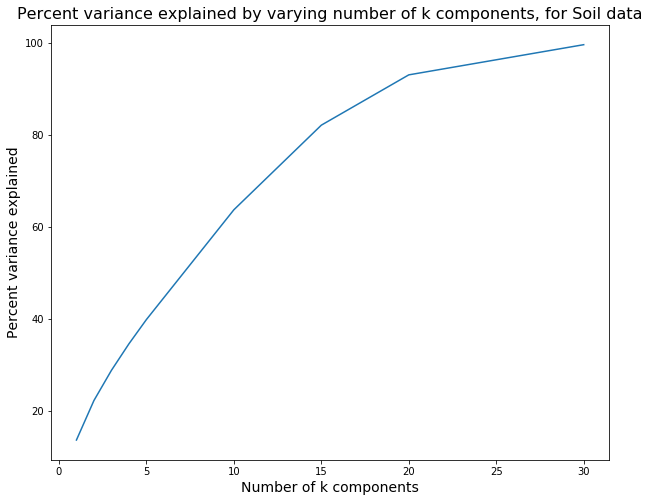

In [40]:
#################################################################################################################
# Principal component analysis with varying components
##################################################################################################################

#List of key components
k=[1, 2, 3, 4, 5, 10, 15, 20, 30]

#List of variances
total_variance_ls = []

#Principal component analysis
for k_value in k:        
    pca = PCA(n_components = k_value)
    pca.fit(X_soil)
    total_variance = 100*sum(pca.explained_variance_ratio_)
    print("The total variance explained by the first", k_value, "component(s) is", round(total_variance,1), "%")
    total_variance_ls.append(total_variance)

#Plotting k components versus variance
plt.figure(figsize=(10,8))
plt.plot(k, total_variance_ls)
plt.title("Percent variance explained by varying number of k components, for Soil data", size = 16)
plt.xlabel('Number of k components', size = 14)
plt.ylabel('Percent variance explained', size=14)

Text(0, 0.5, 'Principal Component 2')

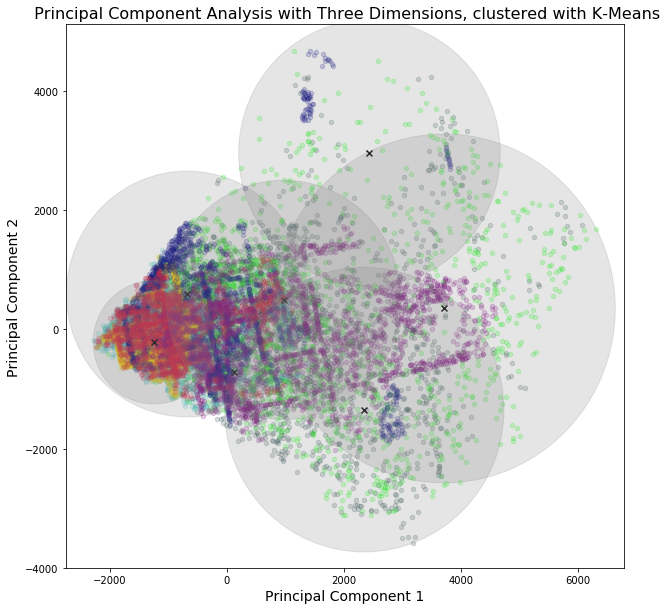

In [113]:
from sklearn.cluster import KMeans

pca = PCA(n_components = 2)
projection = pca.fit_transform(X)
type1 = projection[np.where(y==1)[0],:]
type2 = projection[np.where(y==2)[0],:]
type3 = projection[np.where(y==3)[0],:]
type4 = projection[np.where(y==4)[0],:]
type5 = projection[np.where(y==5)[0],:]
type6 = projection[np.where(y==6)[0],:]
type7 = projection[np.where(y==7)[0],:]

#K-means cluster model with 6 clusters over 2d projected data
km = KMeans(n_clusters=7, init='random', n_init=1, random_state = 12345)
km_model = km.fit(projection, y)
km_clusters = km_model.labels_

#identifying K-means cluster centers and radii
centers = np.array(km_model.cluster_centers_)
clusters_radii=[]
for k in range(7):
    ind = np.where(km_clusters==k)
    projection_k = projection[ind[0],:]
    clusters_radii.append(max([np.linalg.norm(np.subtract(i,centers[k])) for i in zip(projection_k[:,0], projection_k[:,1])]))

#Plotting k-means clustering with 7 clusters over 2d projected data. 
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.cla()
ax.scatter(type1[:,0],  type1[:,1], color = 'darkslategray' , alpha=0.2, s=20, label="Type 1")
ax.scatter(type2[:,0],  type2[:,1], color = 'lime' , alpha=0.2, s=20, label = "Type 2")
ax.scatter(type3[:,0],  type3[:,1], color = 'mediumturquoise' , alpha=0.2, s=20, label = "Type 3")
ax.scatter(type4[:,0],  type4[:,1], color = 'gold' , alpha=0.2, s=20, label = "Type 4")
ax.scatter(type5[:,0],  type5[:,1], color = 'navy' , alpha=0.2, s=20, label = "Type 5")
ax.scatter(type6[:,0],  type6[:,1], color = 'crimson' , alpha=0.2, s=20, label = "Type 6")
ax.scatter(type7[:,0],  type7[:,1], color = 'purple' , alpha=0.2, s=20, label = "Type 7")
ax.scatter(centers[:,0], centers[:,1], marker="x", color='black')  
#ax.set_xlim((-3, 4))
#ax.set_ylim((-4, 4))
for k in range(6):
    ax.add_artist(plt.Circle(centers[k], clusters_radii[k], fill=True, alpha = 0.2, color='grey'))
plt.title(" Principal Component Analysis with Three Dimensions, clustered with K-Means", size = 16)
plt.xlabel('Principal Component 1', size = 14)
plt.ylabel('Principal Component 2', size=14)

### Baseline Machine Learning Technique

Now that we have completed an assessment of our features, we will try a preliminary model to establish our baseline performance. The model we have selected to start with as our baseline is K-Nearest Neighbors. The KNN was selected as a starting model, not only because it is computationally the simplest model to start from, but also our features represent geographical position and therefore, agriculturally, it makes sense that a tree would be the same species as their physically nearby neighbor.

We then included our model in a pipeline to allow us to split the data set into training and validation sets, and to pass in multiple model parameters to be compared. Additionally, it has allowed us to incorporate 10 fold cross validation trials into our model evaluation process.  


In [12]:


def display_CrossValidation_class_level_charts(y_true, y_predict, label_classes):
# ################################################################################
# This function is implemented to display each class level Cross Validation chart
# y_true: Truth data given for lable
# y_predict:  Predicted labels from Machine learning models
# label_Classes: All the labels_class we are trying to predict
# #################################################################################
    fig = plt.figure(figsize=(14,12))
    plt.tight_layout()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2

    for i in range(len(label_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sp = fig.add_subplot(3, 3, i+1)
        sp.set_title('cover_class ' + str( label_classes[i]))
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    plt.show() 


def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):
# ##########################################################################################
# This pipeline funciton is define to centralize Machine Learning pipe line for this project
# ml_name - descriptive name, that can be used for printing
# moddel - Machine Learning Model object like KNN, Logistic or NB
# X_train: Training data
# y_train: label data from training
# X_validation:  Validation data
# y_valid: Label for validation data
# binarize: Some of the Machine Learning models requires binarization and some doesn't
# detailedCVcharts:  This to see details at each class level or not.
# ############################################################################################
# 70% train, 30% test
    # code to replace all negative value with 0 

    lable_classes = classes=[1,2,3,4,5,6,7]
    y_binarized = label_binarize(y, lable_classes)
    
    if binarize:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y_binarized, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, OneVsRestClassifier(model))]) 
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, model)]) 


    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', np.mean(cv_scores))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)


Now we will apply our pipeline to assess the performance of an unweighted KNN model, with varying values of K. Each variation of K will output a performance overview with Precision, Recall, and F1 score and averaged Accuracy across all 10-fold cross validation trials.


In [13]:
# KNN Neighborhood with weights = uniform
knn_values = [1,3,5,7,9]
# knn_values = [3]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value)
    report, y_predict , y_valid= ml_pipleline('KNN with '+ str(value) +'  Neighbors', knn_classifier, \
                                      binarize = False, detailedCVcharts = False )
                       

/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



-146.0 -103.0 1 1
 KNN with 1  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.70      0.68       594
           2       0.60      0.69      0.64       567
           3       0.67      0.79      0.73       568
           4       0.94      0.87      0.90       702
           5       0.94      0.82      0.87       710
           6       0.79      0.72      0.75       698
           7       0.96      0.92      0.94       697

    accuracy                           0.79      4536
   macro avg       0.79      0.79      0.79      4536
weighted avg       0.80      0.79      0.80      4536


 Cross Validation Average Score 0.8343732093800371
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 3  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.67      0.66       613
           2       0.56      0.68      0.61       546
           3       0.67      0.79      0.73       563
           4       0.95      0.86      0.90       718
           5       0.94      0.79      0.86       735
           6       0.77      0.74      0.75       666
           7       0.95      0.92      0.93       695

    accuracy                           0.78      4536
   macro avg       0.78      0.78      0.78      4536
weighted avg       0.80      0.78      0.79      4536


 Cross Validation Average Score 0.8082951780668356
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 5  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.63      0.67      0.65       598
           2       0.57      0.68      0.62       552
           3       0.65      0.78      0.71       563
           4       0.94      0.83      0.89       734
           5       0.93      0.77      0.84       751
           6       0.74      0.72      0.73       659
           7       0.92      0.91      0.92       679

    accuracy                           0.77      4536
   macro avg       0.77      0.77      0.77      4536
weighted avg       0.79      0.77      0.78      4536


 Cross Validation Average Score 0.7895880302243261
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 7  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.62      0.65      0.64       604
           2       0.55      0.66      0.60       539
           3       0.63      0.77      0.69       545
           4       0.94      0.83      0.88       735
           5       0.92      0.77      0.84       745
           6       0.75      0.69      0.72       688
           7       0.92      0.91      0.91       680

    accuracy                           0.76      4536
   macro avg       0.76      0.75      0.75      4536
weighted avg       0.78      0.76      0.77      4536


 Cross Validation Average Score 0.7744700657430862
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 9  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.62      0.65      0.64       610
           2       0.53      0.65      0.58       529
           3       0.60      0.77      0.68       519
           4       0.95      0.82      0.88       749
           5       0.90      0.75      0.82       745
           6       0.76      0.68      0.71       711
           7       0.91      0.91      0.91       673

    accuracy                           0.75      4536
   macro avg       0.75      0.75      0.75      4536
weighted avg       0.77      0.75      0.76      4536


 Cross Validation Average Score 0.7629430696648227


Interestingly we see that the best value of K based on our three-performance metrics is K=1. Normally we would anticipate seeing an increase in performance as the value of K increases.  Let us try weighting the distances and see if we can improve the results.

In [14]:
# KNN with weights = weighted distance (i.e. more weight is given for closer neighbor)
knn_values = [1,3,5,7,9]
# knn_values = [3]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value, weights='distance')
    report, y_predict , y_valid = ml_pipleline('KNN with '+ str(value) +'  Neighbors', knn_classifier, \
                                      binarize = False, detailedCVcharts = False )

-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 1  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.70      0.68       594
           2       0.60      0.69      0.64       567
           3       0.67      0.79      0.73       568
           4       0.94      0.87      0.90       702
           5       0.94      0.82      0.87       710
           6       0.79      0.72      0.75       698
           7       0.96      0.92      0.94       697

    accuracy                           0.79      4536
   macro avg       0.79      0.79      0.79      4536
weighted avg       0.80      0.79      0.80      4536


 Cross Validation Average Score 0.8343732093800371
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 3  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.64      0.70      0.67       582
           2       0.58      0.70      0.63       541
           3       0.66      0.81      0.73       547
           4       0.95      0.86      0.90       722
           5       0.95      0.79      0.86       741
           6       0.79      0.72      0.76       696
           7       0.96      0.91      0.93       707

    accuracy                           0.79      4536
   macro avg       0.79      0.78      0.78      4536
weighted avg       0.81      0.79      0.80      4536


 Cross Validation Average Score 0.8217105697674626
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 5  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.64      0.71      0.67       573
           2       0.58      0.71      0.64       532
           3       0.66      0.81      0.73       543
           4       0.96      0.85      0.90       730
           5       0.95      0.78      0.86       753
           6       0.80      0.73      0.76       703
           7       0.95      0.91      0.93       702

    accuracy                           0.79      4536
   macro avg       0.79      0.79      0.78      4536
weighted avg       0.81      0.79      0.80      4536


 Cross Validation Average Score 0.8117904682342904
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 7  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.63      0.71      0.66       564
           2       0.57      0.70      0.63       534
           3       0.64      0.81      0.72       528
           4       0.95      0.84      0.89       731
           5       0.94      0.77      0.85       757
           6       0.80      0.70      0.75       722
           7       0.95      0.92      0.93       700

    accuracy                           0.78      4536
   macro avg       0.78      0.78      0.78      4536
weighted avg       0.80      0.78      0.79      4536


 Cross Validation Average Score 0.8030034219249533
-146.0 -103.0 1 1


/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 KNN with 9  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.63      0.69      0.66       576
           2       0.55      0.69      0.62       524
           3       0.63      0.81      0.71       522
           4       0.96      0.83      0.89       744
           5       0.94      0.78      0.85       748
           6       0.80      0.70      0.75       727
           7       0.94      0.91      0.93       695

    accuracy                           0.78      4536
   macro avg       0.78      0.77      0.77      4536
weighted avg       0.80      0.78      0.78      4536


 Cross Validation Average Score 0.7942154830947625


Weighting the distances of our KNN does improve the performance of each model for each value of K > 1; however, we still see the best performance overall with K=1. Our speculation for this cause goes back to the large overlap of each features' distribution for the target classes. For example, we see representation of all target classes in the Elevation range 2500 to 3000 (shown again below); this would mean that as our model considers more and more neighbors, there is greater variation in the target classes being voted up by the neighbors. Thus, the more neighbors our model considers, the more like a random guess the prediction gets.

#### Confusion matrix

In [15]:
#Cover type dictionary
cover_dict = {1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}

#Generating a confusion matrix
conf_matrix = confusion_matrix(y_valid, y_predict)
print("The confusion matrix for the 1-NN Classifier:")
print(conf_matrix)
print(" ")
#Transforming the matrix so the diagonal is made of zeros. 
mask = np.ones(conf_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = conf_matrix[mask].max()
conf_matrix_sum = conf_matrix * mask
#Generating the sum of cover type pairs, to find the pair that the algortihm confuses the most
dict_pairs = {}
dict_pairs = {(m,n): conf_matrix_sum[m,n] + conf_matrix_sum[n,m] for m in range(conf_matrix_sum.shape[0]) for n in range(conf_matrix_sum.shape[1]) if m > n}
max_value = max(dict_pairs.values())
max_key = max(dict_pairs, key=dict_pairs.get)
print("The Cover Types pair that gets most often confused is : ", cover_dict[max_key[0] + 1], "and", cover_dict[max_key[1] + 1])
print(" ")

The confusion matrix for the 1-NN Classifier:
[[397 134   2   0  49   4  49]
 [144 363  11   1  86  39  11]
 [  0   7 423  77  15 147   0]
 [  0   0  11 620   0  17   0]
 [  5  13  10   0 580  12   0]
 [  2   2  65  46  12 508   0]
 [ 28   5   0   0   6   0 635]]
 
The Cover Types pair that gets most often confused is :  Lodgepole Pine and Spruce/Fir
 


In [16]:
fig = px.histogram(train_df, x="Elevation", color="Cover_Type", title= "Distribution of Cover Types")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### **Summary**

To conclude our baseline, we have established an initial 1-NN model with avg. Accuracy of 83.4%. We selected accuracy as the performance metric to be evaluated for a few reasons.   

First, it is a easily interpretable metric to allow us to quickly compare our initial models. Secondly, for many of these KNN models with varying K values, we see may equal Precision, Recall, and F1-score, leaving accuracy as the only distinguishing metric between the model variations. 

While we do not know the applied context of our problem to know what metric would be most appropriate to evaluate, we can make educated guesses. For example, if the application of our model is to evaluate fire risk based on the cover type of the area, i.e. the prediction of the cover type determines if the fire risk is 'safe' or 'not-safe'. In this case, we would be more concerned with optimizing model Precision, as our False Positives (predicting a 'safe' cover_type when it is a 'not-safe' cover_type) would carry a high risk. Similarly, we could imagine that Forest Cover Type prediction is useful in monitoring ecosystems. Indeed, having a machine learning model that accurately predicts an expected type of tree (i.e.: optimizing model Precision) could be critical to ensure comparison with the changing reality of cover type due to factors like climate change.   

As such, secondary to accuracy, precision will be relevant to monitor as we assess other machine learning models. In the absence of a clear application, F1-score, a generally used measured that balances precision and recall, will also be worth considering.   

# Improving from the baseline

### Bernouilli Naive Bayes

In [24]:
def binarize_data(data, thresholds=[2600,125,15,50,180,2500,225,220,140,2200]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(10):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_X = binarize_data(X)

In [41]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):

    X_train, X_valid, y_train, y_valid = train_test_split(binarized_X, y, test_size=0.3, random_state=17)
    ml_pipe = Pipeline([('scaler', StandardScaler()), (ml_name, model)])
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [44]:
# BNB
alpha_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
for value in alpha_values:
    BNB_classifier = BernoulliNB(alpha = value)
    report, y_predict , y_valid= ml_pipleline('Bernouilli Naive Bayes with alpha value '+ str(value), BNB_classifier, 
                                               binarize = False, detailedCVcharts = False )

 Bernouilli Naive Bayes with alpha value 1e-10  

Metrics: 
                precision    recall  f1-score   support

           1       0.44      0.31      0.37       881
           2       0.04      0.27      0.08       108
           3       0.29      0.49      0.37       404
           4       0.78      0.60      0.68       845
           5       0.62      0.36      0.46      1059
           6       0.45      0.46      0.45       621
           7       0.36      0.40      0.38       618

    accuracy                           0.42      4536
   macro avg       0.43      0.41      0.40      4536
weighted avg       0.51      0.42      0.45      4536


 Cross Validation Average Score 0.43
 Bernouilli Naive Bayes with alpha value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.44      0.31      0.37       881
           2       0.04      0.27      0.08       108
           3       0.29      0.49      0.37       404
           4       0.78

## Multinomial Naive Bayes

In [47]:
train_df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Rawah_WA', 'Neota_WA',
       'Comanche_Peak_WA', 'Cache_la_Poudre_WA', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type

In [51]:

ls_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

    
categorical_df = train_df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','Wilderness_Areas', 'Soil_Type']]

for x in ls_vars:
    categorical_df[x] = pd.qcut(train_df[x], 4, labels=False)
    
    
categorical_df['Wilderness_Areas']= categorical_df['Wilderness_Areas'].astype('category')
categorical_df['Wilderness_Areas'] = categorical_df['Wilderness_Areas'].cat.codes

categorical_df['Soil_Type']= categorical_df['Soil_Type'].astype('category')
categorical_df['Soil_Type'] = categorical_df['Soil_Type'].cat.codes

categorical_X = np.array(categorical_df)

In [71]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):

    X_train, X_valid, y_train, y_valid = train_test_split(categorical_X, y, test_size=0.3, random_state=17)
    ml_pipe = Pipeline([('scaler', MinMaxScaler()), (ml_name, model)])
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [72]:
# MNB
alpha_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
for value in alpha_values:
    MNB_classifier = MultinomialNB(alpha = value)
    report, y_predict , y_valid= ml_pipleline('Multinomial Naive Bayes with alpha value '+ str(value), MNB_classifier, 
                                               binarize = False, detailedCVcharts = False )

 Multinomial Naive Bayes with alpha value 1e-10  

Metrics: 
                precision    recall  f1-score   support

           1       0.48      0.37      0.42       818
           2       0.28      0.42      0.34       436
           3       0.27      0.50      0.35       362
           4       0.82      0.77      0.79       693
           5       0.51      0.35      0.41       919
           6       0.46      0.40      0.43       737
           7       0.51      0.60      0.55       571

    accuracy                           0.48      4536
   macro avg       0.48      0.49      0.47      4536
weighted avg       0.50      0.48      0.48      4536


 Cross Validation Average Score 0.485
 Multinomial Naive Bayes with alpha value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.48      0.37      0.42       818
           2       0.28      0.42      0.34       436
           3       0.27      0.50      0.35       362
           4       0

In [63]:
#Need for calibration???

## Logistic Regression

#### All data

In [73]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):
# ##########################################################################################
# This pipeline funciton is define to centralize Machine Learning pipe line for this project
# ml_name - descriptive name, that can be used for printing
# moddel - Machine Learning Model object like KNN, Logistic or NB
# X_train: Training data
# y_train: label data from training
# X_validation:  Validation data
# y_valid: Label for validation data
# binarize: Some of the Machine Learning models requires binarization and some doesn't
# detailedCVcharts:  This to see details at each class level or not.
# ############################################################################################
# 70% train, 30% test
    # code to replace all negative value with 0 

    lable_classes = classes=[1,2,3,4,5,6,7]
    y_binarized = label_binarize(y, lable_classes)
    
    if binarize:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y_binarized, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, OneVsRestClassifier(model))]) 
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, model)]) 


    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', np.mean(cv_scores))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [84]:
# Logistic regression
C_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2.0, 10]
for value in C_values:
    clf = LogisticRegression(random_state=None, C=value, solver="newton-cg", multi_class="multinomial", max_iter=2000)
    report, y_predict , y_valid= ml_pipleline('Multinomial Logistic Regression with C value '+ str(value), clf, 
                                               binarize = False, detailedCVcharts = False )

/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error



 Multinomial Logistic Regression with C value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.55      0.51      0.53       687
           2       0.47      0.55      0.51       561
           3       0.35      0.53      0.42       440
           4       0.85      0.67      0.75       825
           5       0.61      0.59      0.60       646
           6       0.60      0.51      0.55       735
           7       0.83      0.88      0.85       642

    accuracy                           0.61      4536
   macro avg       0.61      0.61      0.60      4536
weighted avg       0.63      0.61      0.62      4536



KeyboardInterrupt: 

#### Binarized data

In [85]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):

    X_train, X_valid, y_train, y_valid = train_test_split(binarized_X, y, test_size=0.3, random_state=17)
    ml_pipe = Pipeline([('scaler', StandardScaler()), (ml_name, model)])
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [86]:
C_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2.0, 10]
for value in C_values:
    clf = LogisticRegression(random_state=None, C=value, solver="newton-cg", multi_class="multinomial", max_iter=1000)
    report, y_predict , y_valid= ml_pipleline('Multinomial Logistic Regression with C value '+ str(value), clf, 
                                               binarize = False, detailedCVcharts = False )

 Multinomial Logistic Regression with C value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.45      0.31      0.37       928
           2       0.03      0.27      0.06        78
           3       0.19      0.53      0.28       239
           4       0.92      0.53      0.67      1121
           5       0.58      0.36      0.44       999
           6       0.44      0.47      0.45       593
           7       0.37      0.43      0.40       578

    accuracy                           0.42      4536
   macro avg       0.43      0.41      0.38      4536
weighted avg       0.56      0.42      0.46      4536


 Cross Validation Average Score 0.407
 Multinomial Logistic Regression with C value 0.001  

Metrics: 
                precision    recall  f1-score   support

           1       0.34      0.35      0.35       626
           2       0.09      0.28      0.14       221
           3       0.30      0.45      0.36       451
           4

#### Categorical data

In [87]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):

    X_train, X_valid, y_train, y_valid = train_test_split(categorical_X, y, test_size=0.3, random_state=17)
    ml_pipe = Pipeline([('scaler', StandardScaler()), (ml_name, model)])
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [90]:
C_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2.0, 10]
for value in C_values:
    clf = LogisticRegression(random_state=None, C=value, solver="newton-cg", multi_class="multinomial", penalty = 'l2', max_iter=1000)
    report, y_predict , y_valid= ml_pipleline('Multinomial Logistic Regression with C value '+ str(value), clf, 
                                               binarize = False, detailedCVcharts = False )

 Multinomial Logistic Regression with C value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.45      0.45      0.45       634
           2       0.14      0.44      0.22       214
           3       0.19      0.46      0.27       275
           4       0.84      0.53      0.65      1031
           5       0.45      0.57      0.50       481
           6       0.58      0.47      0.52       793
           7       0.91      0.55      0.69      1108

    accuracy                           0.51      4536
   macro avg       0.51      0.49      0.47      4536
weighted avg       0.64      0.51      0.55      4536


 Cross Validation Average Score 0.444
 Multinomial Logistic Regression with C value 0.001  

Metrics: 
                precision    recall  f1-score   support

           1       0.41      0.52      0.46       500
           2       0.35      0.48      0.41       479
           3       0.30      0.46      0.37       435
           4

#### Mix of continuous and catgeorical

In [112]:
new_df = train_df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']]

In [113]:
new_df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

In [114]:
new_df['Wilderness_Areas']= train_df['Wilderness_Areas'].astype('category')
new_df['Wilderness_Areas'] = new_df['Wilderness_Areas'].cat.codes

#new_df['Soil_Type']= train_df['Soil_Type'].astype('category')
#new_df['Soil_Type'] = new_df['Soil_Type'].cat.codes

new_X = np.array(new_df)

/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/valeriemeausoone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [111]:
new_X.shape

(15120, 12)

In [115]:
def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):

    X_train, X_valid, y_train, y_valid = train_test_split(new_X, y, test_size=0.3, random_state=17)
    ml_pipe = Pipeline([('scaler', StandardScaler()), (ml_name, model)])
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict, y_valid)

In [118]:
C_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2.0, 10]
for value in C_values:
    clf = LogisticRegression(random_state=None, C=value, solver="saga", multi_class="multinomial", penalty = 'l2', max_iter=5000)
    report, y_predict , y_valid= ml_pipleline('Multinomial Logistic Regression with C value '+ str(value), clf, 
                                               binarize = False, detailedCVcharts = False )
    
    

 Multinomial Logistic Regression with C value 0.0001  

Metrics: 
                precision    recall  f1-score   support

           1       0.46      0.40      0.43       739
           2       0.18      0.47      0.26       260
           3       0.16      0.49      0.24       211
           4       0.86      0.45      0.59      1232
           5       0.43      0.50      0.46       538
           6       0.50      0.44      0.47       730
           7       0.66      0.54      0.59       826

    accuracy                           0.46      4536
   macro avg       0.47      0.47      0.44      4536
weighted avg       0.58      0.46      0.50      4536


 Cross Validation Average Score 0.599
 Multinomial Logistic Regression with C value 0.001  

Metrics: 
                precision    recall  f1-score   support

           1       0.39      0.45      0.42       546
           2       0.32      0.45      0.38       464
           3       0.26      0.45      0.33       387
           4